In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pickle

In [6]:
train_dir = "/content/drive/MyDrive/Cattle Classification/data/train"
val_dir = "/content/drive/MyDrive/Cattle Classification/data/val"
test_dir = "/content/drive/MyDrive/Cattle Classification/data/test"

IMG_SIZE = 224

In [ ]:
# data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    rotation_range = 15,
    horizontal_flip = True,
    width_shift_range=0.10,
    height_shift_range=0.10,
    zoom_range = 0.2,
    fill_mode = "nearest"
)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = 32,
    class_mode = "categorical",
    shuffle = True
)

# no augmentation
val_datagen = ImageDataGenerator(preprocessing_function= preprocess_input)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = 32,
    class_mode = "categorical",
    shuffle = False
)

# no augmentation
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = 32,
    class_mode = "categorical",
    shuffle = False
)

# load base modal with transfer learning
base_model = ResNet50(include_top=False, weights="imagenet", input_shape=(IMG_SIZE, IMG_SIZE, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.4)(x)
output = Dense(5, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

# compile with Adam optimizer
model.compile(
    optimizer = Adam(learning_rate=0.001),
    loss = "categorical_crossentropy",
    metrics = ["accuracy"]
)

if __name__ == "__main__":

  history = model.fit(
    train_data,
    validation_data = val_data,
    epochs = 15,
    verbose = 1
  )

  # save trained model
  model.save("/content/drive/MyDrive/Cattle Classification/saved_models/resnet50.h5")

  with open("/content/drive/MyDrive/Cattle Classification/saved_models/history_resnet50.pkl", "wb") as f:
    pickle.dump(history.history, f)

test_loss, test_acc = model.evaluate(test_data, verbose=1)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

Found 965 images belonging to 5 classes.
Found 119 images belonging to 5 classes.
Found 124 images belonging to 5 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 351s 11s/step - accuracy: 0.4394 - loss: 1.6829 - val_accuracy: 0.7395 - val_loss: 0.6653
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 16s 505ms/step - accuracy: 0.7379 - loss: 0.7838 - val_accuracy: 0.8067 - val_loss: 0.5732
Epoch 3/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 16s 506ms/step - accuracy: 0.8131 - loss: 0.5644 - val_accuracy: 0.8739 - val_loss: 0.4807
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 16s 504ms/step - accuracy: 0.8448 - loss: 0.4696 - val_accuracy: 0.8487 - val_loss: 0.4594
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 16s 505ms/step - accuracy: 0.8551 - loss: 0.3894 - val_accuracy: 0.8487 - val_loss: 0.3999
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 17s 541ms/step - accuracy: 0.8768 - loss: 0.3452 - val_accuracy: 0.8571 - val_loss: 0.3808
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 16s 504ms/step - accuracy: 0.8828 - loss: 0.3718 - val_accuracy: 0.8824 - val_loss: 0.3855
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 16s 501ms/step - accuracy: 0.9126 - loss: 0.2882 - val_accur

4/4 ━━━━━━━━━━━━━━━━━━━━ 33s 11s/step - accuracy: 0.8294 - loss: 0.5756
Test Loss: 0.4704 | Test Acc: 0.8548


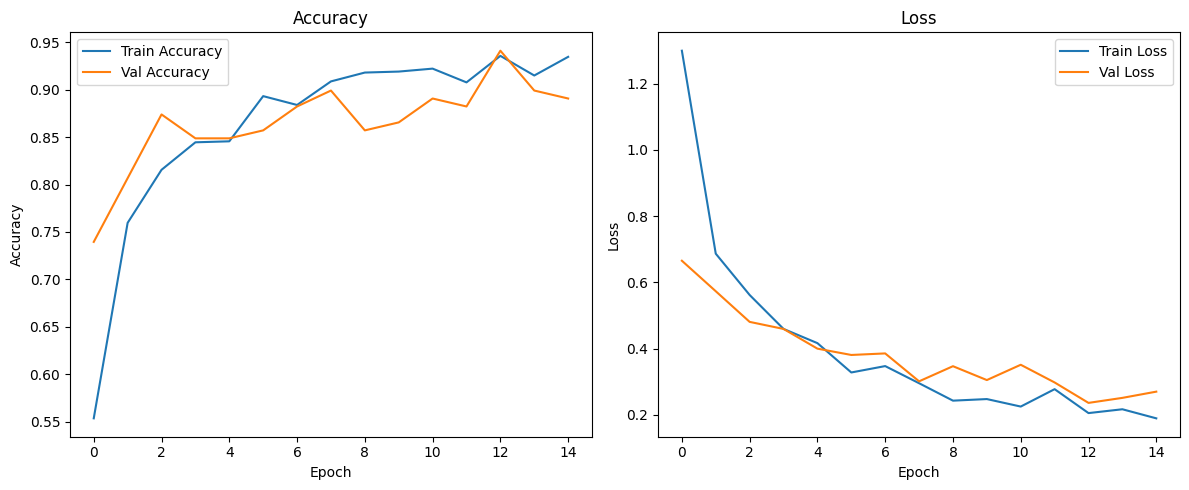

In [3]:
with open("/content/drive/MyDrive/Cattle Classification/saved_models/history_resnet50.pkl", "rb") as f:
    history_dict = pickle.load(f)

acc = history_dict["accuracy"]
vall_acc = history_dict["val_accuracy"]
loss = history_dict["loss"]
vall_loss = history_dict["val_loss"]

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label= "Train Accuracy")
plt.plot(epochs_range, vall_acc, label= "Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label= "Train Loss")
plt.plot(epochs_range, vall_loss, label= "Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("/content/drive/MyDrive/Cattle Classification/saved_models/resnet50.h5")

In [7]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = 32,
    class_mode = "categorical",
    shuffle = False
)

Found 124 images belonging to 5 classes.


In [8]:
import numpy as np
from sklearn.metrics import classification_report

y_true = test_data.classes
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)

class_labels = list(test_data.class_indices.keys())

print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_labels))

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 57s 16s/step
Classification Report:
                           precision    recall  f1-score   support

         Ayrshire cattle       0.73      0.85      0.79        26
      Brown Swiss cattle       0.86      0.76      0.81        25
Holstein Friesian cattle       0.92      0.92      0.92        26
           Jersey cattle       0.83      0.92      0.87        26
         Red Dane cattle       1.00      0.81      0.89        21

                accuracy                           0.85       124
               macro avg       0.87      0.85      0.86       124
            weighted avg       0.86      0.85      0.86       124



4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


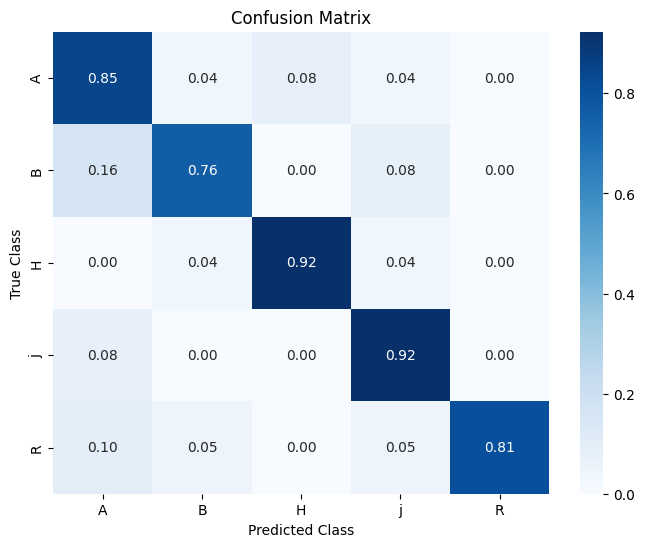

In [10]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_true = test_data.classes
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)

# A: Aysrhire, B: Brown Swiss, H: Holstein Friesian, J: Jersey, R: Red Dane
class_names = ["A", "B", "H", "j", "R"]

cm = confusion_matrix(y_true, y_pred_classes)
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8,6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()